In [1]:
import numpy as np
import h5py

#f = h5py.File("/oak/stanford/groups/akundaje/avsec/basepair/data/"
#              +"processed/comparison/output/nexus,peaks,OSNK,0,10"
#              +",1,FALSE,same,0.5,64,25,0.004,9,FALSE,[1,50],TRUE"
#              +",FALSE,1/deeplift.imp_score.h5", "r")
f = h5py.File("deeplift.imp_score.h5","r")
nanog_mask = np.array(f['metadata']['interval_from_task'][:]=='Nanog')
nanog_profile_wn_hypimp = np.array(f["hyp_imp/Nanog/profile/wn"][:])[nanog_mask]
onehot_seq = np.array(f["inputs/seq"][:])[nanog_mask]
nanog_profile_wn_contribs = nanog_profile_wn_hypimp*onehot_seq

In [5]:
#print modisco commit hash
%cd /users/avanti/tfmodisco
!git log -n 1
%cd /users/avanti/tfmodisco_bio_experiments/bpnet/trial1

from importlib import reload

%matplotlib inline
import h5py
import numpy as np
import modisco
import modisco.seqlet_embedding.advanced_gapped_kmer
reload(modisco.seqlet_embedding.advanced_gapped_kmer)
import modisco.seqlet_embedding
reload(modisco.seqlet_embedding)
import modisco
reload(modisco)
reload(modisco.util)
import modisco.cluster.phenograph.core
reload(modisco.cluster.phenograph.core)
import modisco.cluster.phenograph.cluster
reload(modisco.cluster.phenograph.cluster)
import modisco.cluster.phenograph
reload(modisco.cluster.phenograph)
import modisco.cluster.core
reload(modisco.cluster.core)
import modisco.cluster
reload(modisco.cluster)
import modisco.affinitymat.core
reload(modisco.affinitymat.core)
import modisco.affinitymat.transformers
reload(modisco.affinitymat.transformers)
import modisco.tfmodisco_workflow.seqlets_to_patterns
reload(modisco.tfmodisco_workflow.seqlets_to_patterns)
import modisco.tfmodisco_workflow.workflow
reload(modisco.tfmodisco_workflow.workflow)
import modisco.nearest_neighbors
reload(modisco.nearest_neighbors)
import modisco.affinitymat
reload(modisco.affinitymat)
import modisco.aggregator
reload(modisco.aggregator)
import modisco.value_provider
reload(modisco.value_provider)
import modisco.core
reload(modisco.core)
import modisco.coordproducers
reload(modisco.coordproducers)
import modisco.metaclusterers
reload(modisco.metaclusterers)
import modisco.clusterinit.memeinit
reload(modisco.clusterinit.memeinit)

import h5py
import numpy as np
from importlib import reload
import modisco
reload(modisco.util)
reload(modisco.core)
reload(modisco.tfmodisco_workflow)
from modisco.tfmodisco_workflow import workflow

track_set = modisco.tfmodisco_workflow.workflow.prep_track_set(
    task_names=["Nanog_profile_wn"],
    contrib_scores={'Nanog_profile_wn': nanog_profile_wn_contribs},
    hypothetical_contribs={'Nanog_profile_wn': nanog_profile_wn_hypimp},
    one_hot=onehot_seq)

file_path = "v0.5.14.0_minratherthanavgmerge.hdf5"
grp = h5py.File(file_path,"r")
loaded_tfmodisco_results =\
    workflow.TfModiscoResults.from_hdf5(grp, track_set=track_set)
grp.close()

/mnt/lab_data2/avanti/tfmodisco
commit 2ece4ac27db02c282ba6074db40e0c14b7af21d2 (HEAD -> dev, origin/dev)
Author: Av Shrikumar <avanti.shrikumar@gmail.com>
Date:   Tue Mar 2 14:03:10 2021 -0800

    added on-the-fly flank filling
/mnt/lab_data2/avanti/tfmodisco_bio_experiments/bpnet/trial1


Subcluster: 0 size: 1110


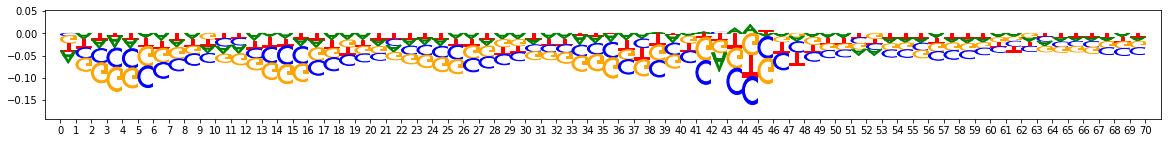

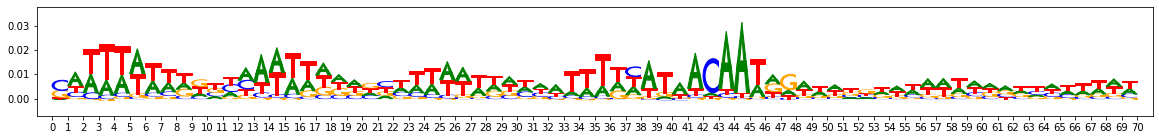

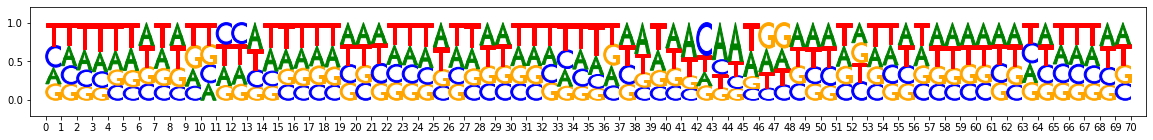

Subcluster: 1 size: 851


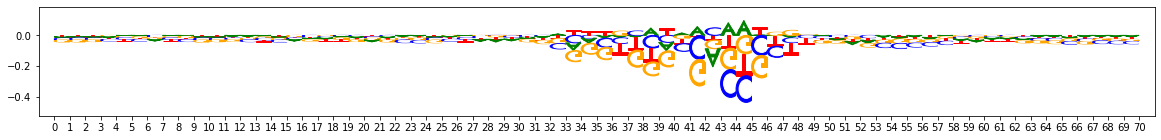

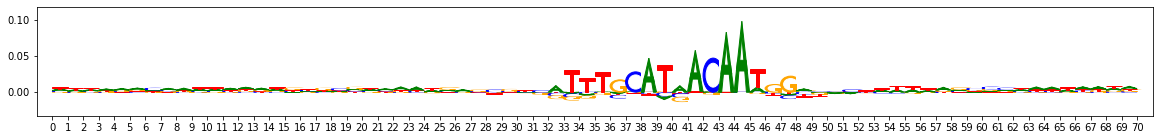

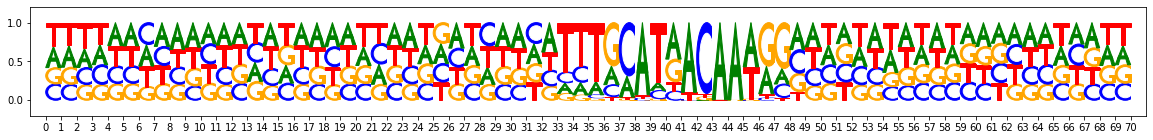

Subcluster: 2 size: 825


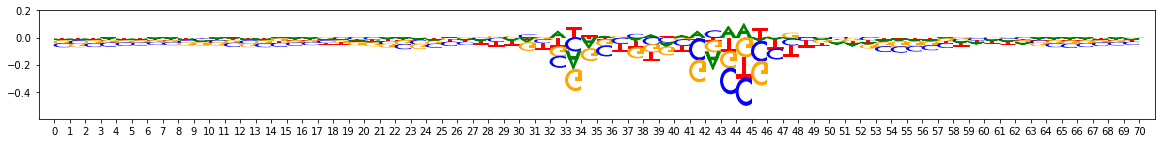

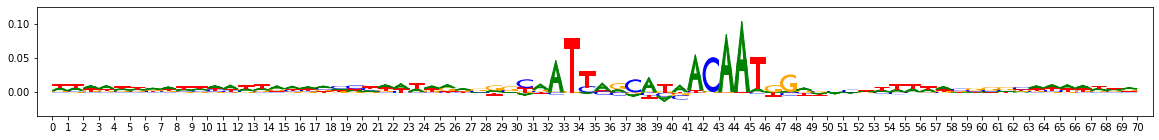

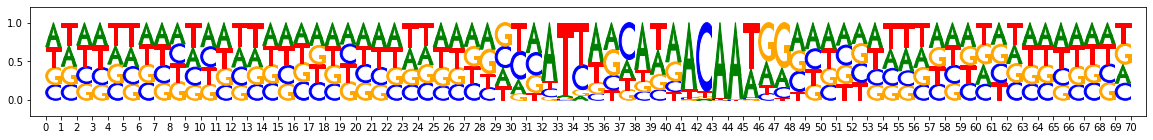

Subcluster: 3 size: 692


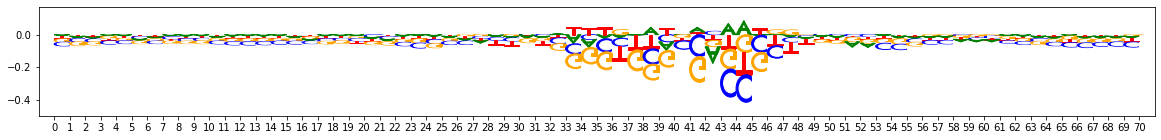

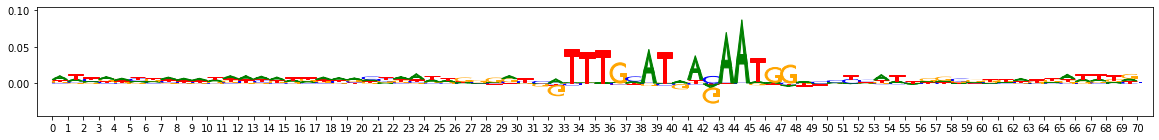

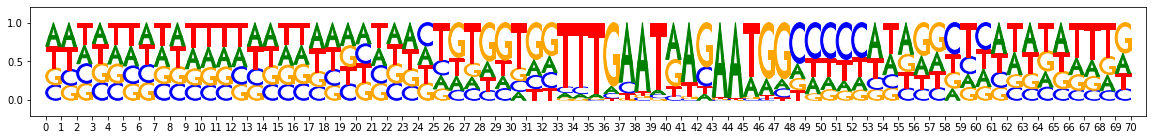

Subcluster: 4 size: 605


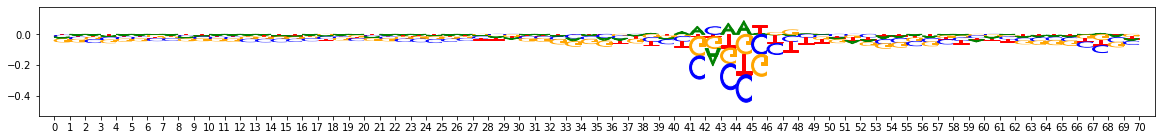

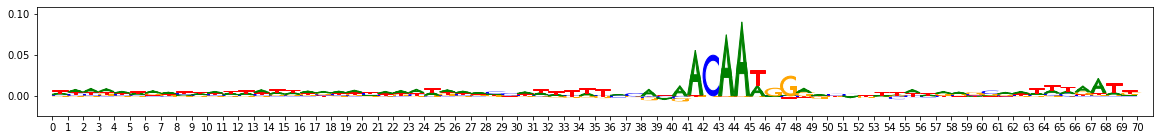

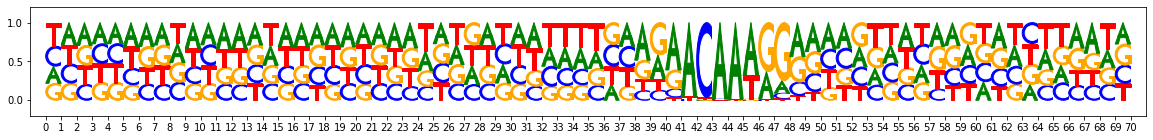

Subcluster: 5 size: 523


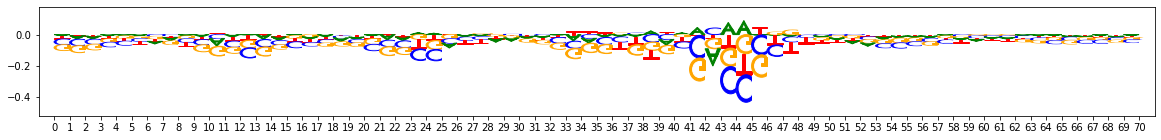

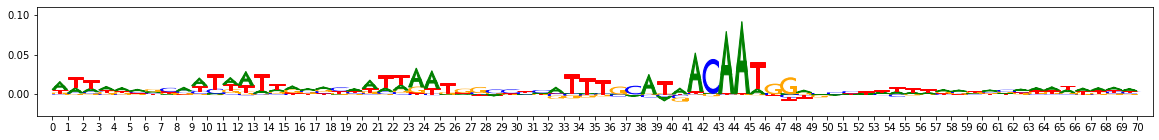

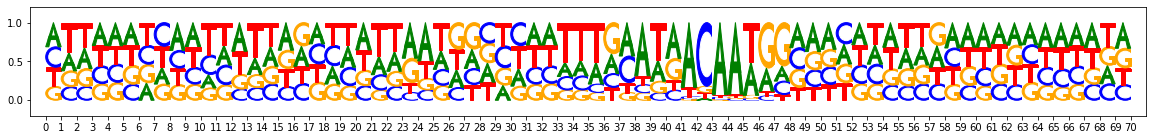

Subcluster: 6 size: 420


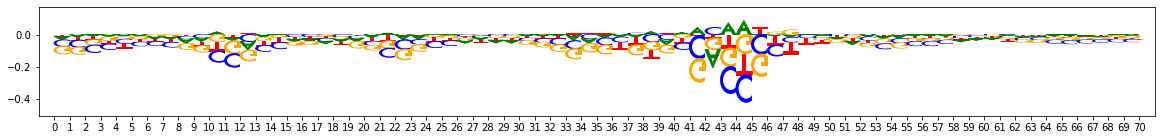

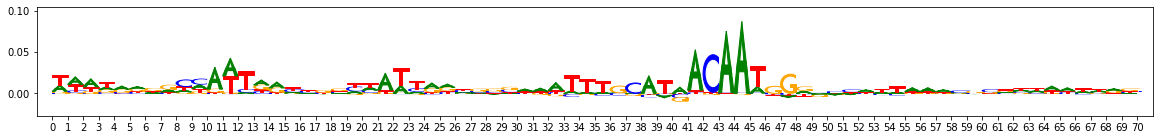

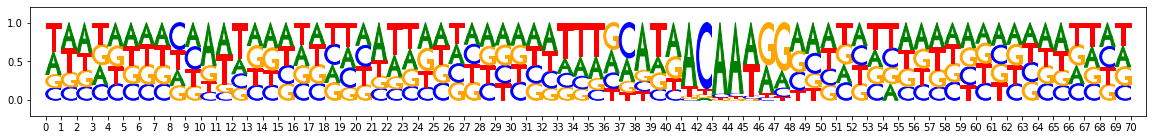

Subcluster: 7 size: 400


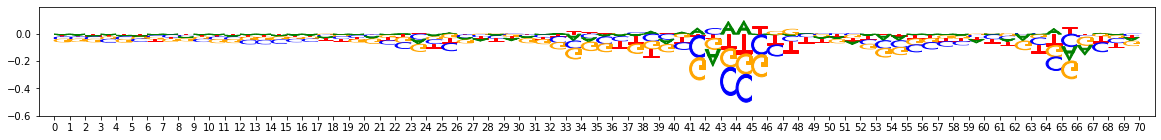

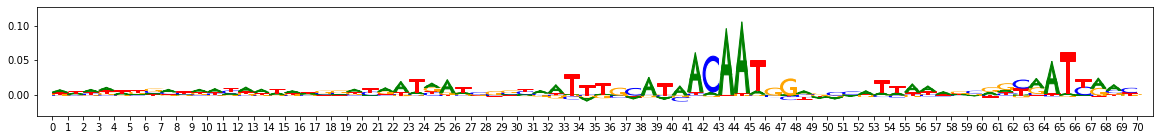

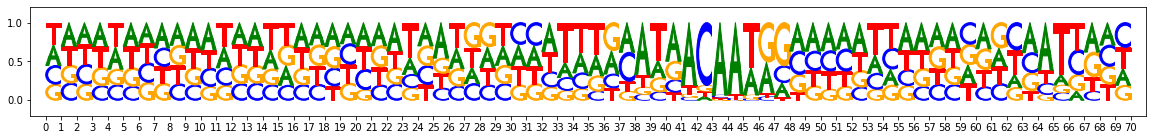

Subcluster: 8 size: 389


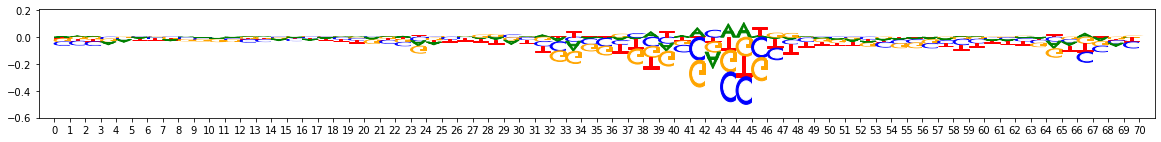

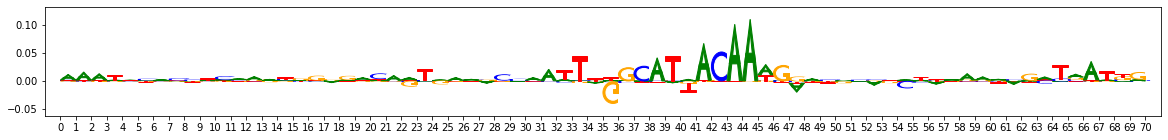

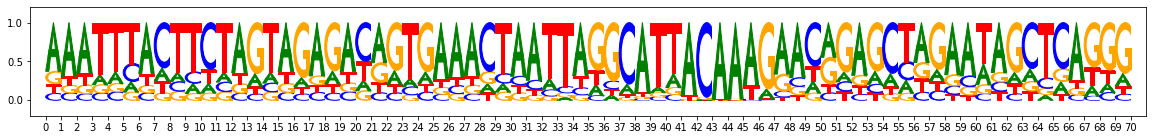

Subcluster: 9 size: 238


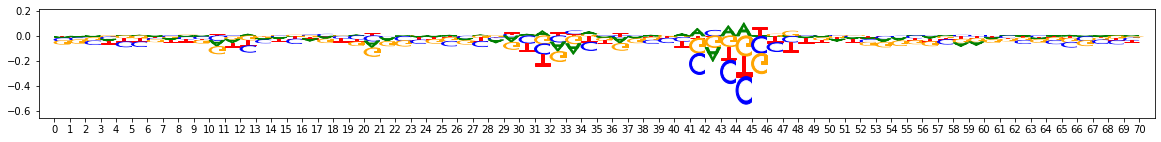

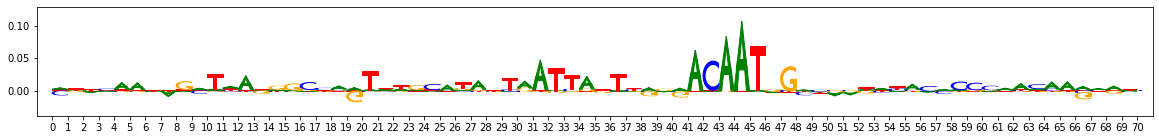

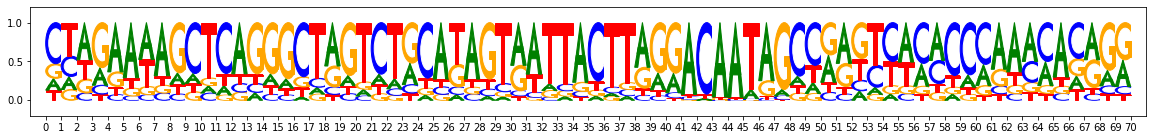

Subcluster: 10 size: 221


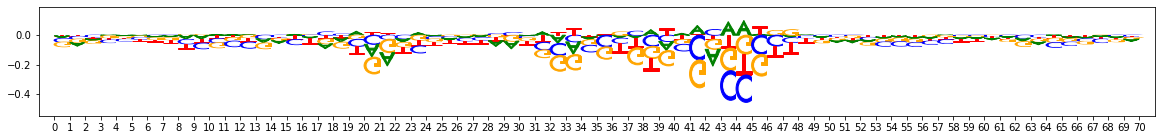

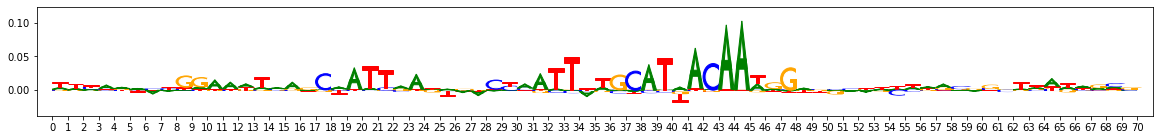

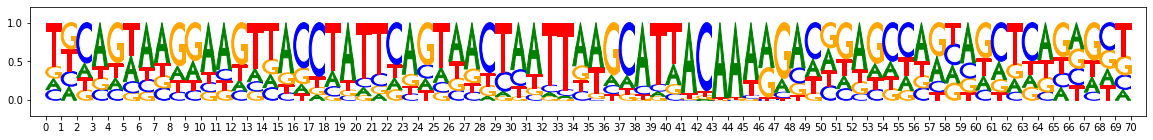

Subcluster: 11 size: 216


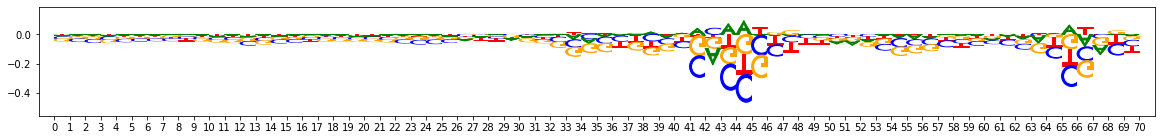

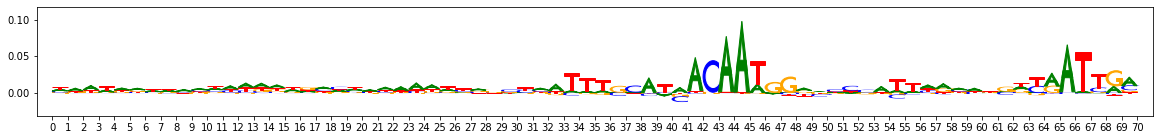

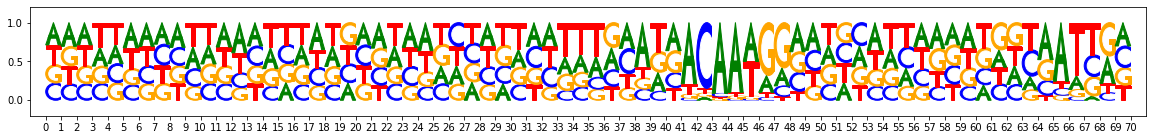

Subcluster: 12 size: 183


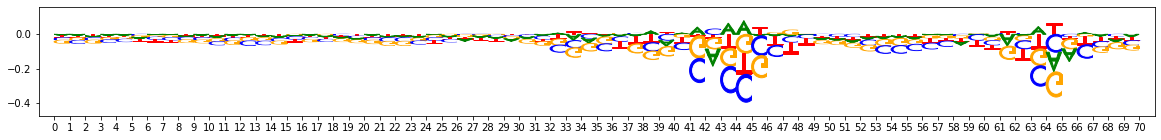

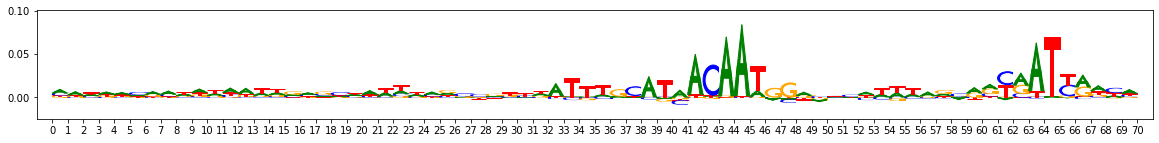

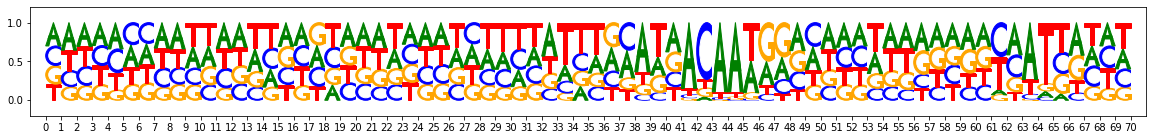

Subcluster: 13 size: 10


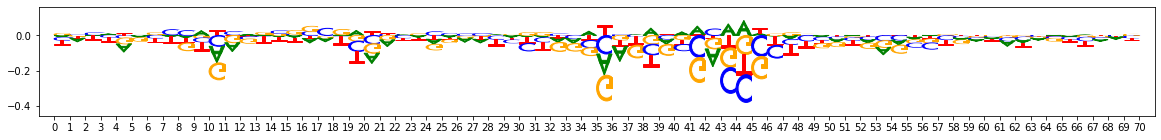

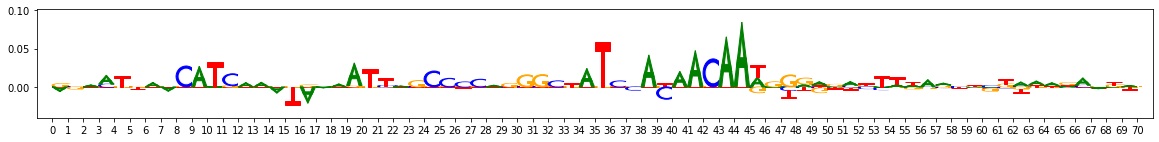

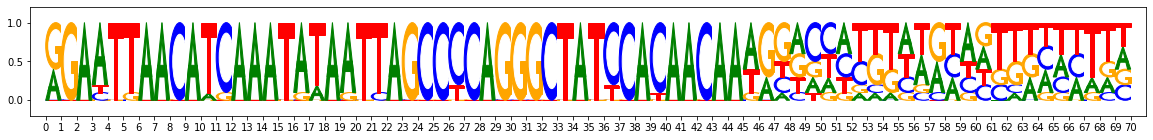

In [9]:
#let's study the subpatterns for oct4
from matplotlib import pyplot as plt
from modisco.visualization import viz_sequence

patterns = (loaded_tfmodisco_results
            .metacluster_idx_to_submetacluster_results["metacluster_0"]
            .seqlets_to_patterns_result.patterns)

pattern_to_study = patterns[1]
subpatterns = pattern_to_study.subcluster_to_subpattern.values()
for subcluster, subpattern in enumerate(subpatterns):
        print("Subcluster:",subcluster,"size:",len(subpattern.seqlets))
        #plt.scatter(twod_embedding[:,0], twod_embedding[:,1], c=(subclusters==subcluster))
        #plt.show()
        viz_sequence.plot_weights(subpattern["Nanog_profile_wn_hypothetical_contribs"].fwd)
        viz_sequence.plot_weights(subpattern["Nanog_profile_wn_contrib_scores"].fwd)
        viz_sequence.plot_weights(subpattern["sequence"].fwd)

In [27]:
import modisco


def prepare_pairwise_mat(aligner, patterns):
    pairwise_sims = np.zeros((len(patterns),len(patterns)))
    for i,pattern1 in enumerate(patterns):
        for j,pattern2 in enumerate(patterns):
            pairwise_sims[i,j] = aligner(pattern1, pattern2)[-1]
    return pairwise_sims


min_overlap_while_sliding = 0.7


pattern_comparison_settings = modisco.affinitymat.core.PatternComparisonSettings(                         
                track_names=["Nanog_profile_wn_contrib_scores",
                             "Nanog_profile_wn_hypothetical_contribs"],                      
                track_transformer=modisco.affinitymat.L1Normalizer(),                   
                min_overlap=min_overlap_while_sliding)


standard_crosscorr_aligner = modisco.core.CrossCorrelationPatternAligner(
            pattern_comparison_settings=
                modisco.affinitymat.core.PatternComparisonSettings(
                    track_names=["Nanog_profile_wn_contrib_scores"],                  
                    track_transformer=                                  
                        modisco.affinitymat.MeanNormalizer().chain(             
                        modisco.affinitymat.MagnitudeNormalizer()),             
                    min_overlap=min_overlap_while_sliding))

prob_and_sim_merge_thresholds = [(0.8,0.8), (0.5, 0.85), (0.2, 0.9)]
prob_and_sim_dealbreaker_thresholds = [(0.4, 0.75), (0.2,0.8), (0.1, 0.85), (0.0,0.9)]
merging_max_seqlets_subsample=100

similar_patterns_collapser = modisco.aggregator.DynamicDistanceSimilarPatternsCollapser2(                
                pattern_comparison_settings=pattern_comparison_settings,        
                track_set=track_set,                                            
                pattern_aligner=standard_crosscorr_aligner,       
                collapse_condition=(lambda prob, aligner_sim:                   
                    any([(prob >= x[0] and aligner_sim >= x[1])                 
                         for x in prob_and_sim_merge_thresholds])),             
                dealbreaker_condition=(lambda prob, aligner_sim:                
                    any([(prob <= x[0] and aligner_sim <= x[1])                 
                         for x in prob_and_sim_dealbreaker_thresholds])),       
                postprocessor=None,                                   
                verbose=True,                                           
                max_seqlets_subsample=merging_max_seqlets_subsample,       
                n_cores=10) 


#aligner1_pairwisesims = prepare_pairwise_mat(aligner=aligner1,
#                                             patterns=subpatterns)

collapsed_patterns = similar_patterns_collapser(subpatterns)

On merging iteration 1
Numbers for each pattern pre-subsample: [1110, 851, 825, 692, 605, 523, 420, 400, 389, 238, 221, 216, 183, 10]
Numbers after subsampling: [100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 10]
Computing sims for pattern 0
Computed sims for pattern 0 in 4.489312410354614 s
Computing sims for pattern 1
Computed sims for pattern 1 in 2.2707955837249756 s
Computing sims for pattern 2
Computed sims for pattern 2 in 2.4734725952148438 s
Computing sims for pattern 3
Computed sims for pattern 3 in 2.368835926055908 s
Computing sims for pattern 4
Computed sims for pattern 4 in 2.5217478275299072 s
Computing sims for pattern 5
Computed sims for pattern 5 in 2.3610193729400635 s
Computing sims for pattern 6
Computed sims for pattern 6 in 2.472318172454834 s
Computing sims for pattern 7
Computed sims for pattern 7 in 2.297649621963501 s
Computing sims for pattern 8
Computed sims for pattern 8 in 2.3846170902252197 s
Computing sims for pattern 9
Computed sims f

TypeError: 'NoneType' object is not callable

In [19]:
aligner1_pairwisesims

array([[1.        , 0.75698059, 0.69930466, 0.71456882, 0.73863069,
        0.7499738 , 0.72448441, 0.69167638, 0.68356271, 0.63136538,
        0.64404994, 0.6603518 , 0.59316849, 0.58228581],
       [0.75698059, 1.        , 0.88883018, 0.9046072 , 0.89260528,
        0.91524884, 0.90052069, 0.86516554, 0.89240821, 0.74908295,
        0.88105845, 0.81522767, 0.79474773, 0.74376908],
       [0.69930466, 0.88883018, 1.        , 0.81606547, 0.84276084,
        0.87146121, 0.86131086, 0.84101714, 0.82043096, 0.76724512,
        0.81448389, 0.7920772 , 0.7625083 , 0.618219  ],
       [0.71456882, 0.9046072 , 0.81606547, 1.        , 0.73655834,
        0.83896081, 0.79349092, 0.76167426, 0.78513808, 0.64541427,
        0.79080418, 0.75192365, 0.70492693, 0.66695939],
       [0.73863069, 0.89260528, 0.84276084, 0.73655834, 1.        ,
        0.8975887 , 0.89856921, 0.86931529, 0.83925856, 0.82934395,
        0.80620093, 0.81486461, 0.78340645, 0.73778707],
       [0.7499738 , 0.91524884, 0.8